## Summary of the progress:
- Randomly choose 100000 data points from the data snippet. 
- Construct the contexts and the reward vectors.
- Run the ContextualBandit: for every 1000 contexts seen, the following steps are done:
    1. Run the algorithm(in this example it is LinUCB), store the 1000 seen rewards together with their contexts.
    2. Then train the Wide and Deep model on these 1000 data points for 10 epoches.
    3. Then update the algorithm's parameters (For LinUCB, they are A matrix and B vector) according to all the historical data points in order to keep the algorithm's knowledge by far.
    4. Output the time spent on this 1000 data points. 

- finally plot the cumulative rewards, and print the accuracy.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
from collections import OrderedDict

class Wide_Deep(nn.Module):
    def __init__(self, wide_dim, deep_dim, action_dim, embeddings={}, deep_neurons=[32, 16], activation=nn.ReLU()):
        
        super(Wide_Deep, self).__init__()
        self.wide_dim = wide_dim
        self.deep_dim = deep_dim
        self.context_dim = wide_dim + deep_dim
        self.action_dim = action_dim
        self.deep_neurons = deep_neurons

        self.add_module('wide', nn.Module())
        self.add_module('deep', nn.Module())

        dims = {'wide':wide_dim, 'deep':deep_dim}
        for name, child_module in self.named_children():
            if name in embeddings.keys():
                assert dims[name] >= len(embeddings[name]), "Number of {} embedding features defined in embeddings should not more than {}_dim.".format(name, name)
                for embed in embeddings[name]:
                    child_module.add_module(embed[0], nn.Embedding(embed[1], embed[2]))
                    dims[name] += -1
                    dims[name] += embed[2]  
        self.dims = dims

        if self.dims['deep'] == 0:
            assert (self.dims['wide'] > 0), "Both wide_dim and deep_dim are 0, at least one of them needs a positive value." 
            print("This is a wide-only model.")
            self.z_dim = self.dims['wide']
        else:
            if self.dims['wide'] == 0:
                print("This is a deep-only model.")
            else:
                print("This is a wide and deep model.")
            assert len(deep_neurons) > 0, "deep_neurons must not be empty for the deep part."
            deep_layers = OrderedDict()
            layer_in = self.dims['deep']
            for i, layer_out in enumerate(deep_neurons):
                deep_layers['fc{}'.format(i)] = nn.Linear(layer_in, layer_out)
                deep_layers['activ{}'.format(i)] = activation
                layer_in = layer_out
            self.deep.add_module('NN', nn.Sequential(deep_layers))
            self.z_dim = self.dims['wide'] + deep_neurons[-1]

        self.lastlayer = nn.Linear(self.z_dim, self.action_dim)

    def get_z(self, x):
        inputs = {'wide':x[:, :self.wide_dim], 'deep':x[:, self.wide_dim:]}
        
        after_embed = {}
        for name, module in self.named_children():
            if name not in ['wide', 'deep']:
                break;
            i = 0
            for child in module.children():
                if 'Embedding' in torch.typename(child):
                    if name not in after_embed:
                        after_embed[name] = child(inputs[name][:, i].long())
                        i += 1
                    else:
                        after_embed[name] = torch.cat((after_embed[name], child(inputs[name][:, i].long())), dim=1)
                        i += 1 
            if name not in after_embed:
                after_embed[name] = inputs[name]
            else:
                after_embed[name] = torch.cat((after_embed[name], inputs[name][:, i:]), dim=1)

        if self.dims['deep'] == 0:
            z = after_embed['wide']
        elif self.dims['wide'] == 0:
            z = self.deep.NN(after_embed['deep'])
        else:
            z = torch.cat((after_embed['wide'], self.deep.NN(after_embed['deep'])), dim=1)
        
        return z

    def forward(self, x):
        z = self.get_z(x)
        out = self.lastlayer(z)
        return out
                

class ContextualBandit():
    
    def __init__(self, device, model, optimizer, loss_func, algorithm):
        self.device = device
        self.model = model.to(device)
        self.context_dim = model.context_dim
        self.z_dim = model.z_dim
        self.action_dim = model.action_dim
        self.optimizer = optimizer
        self.loss_func = loss_func
        self.algorithm = algorithm
        self.reset()
        
    def reset(self):
        self.dataset = []
    
    def observe_data(self, context_source):
        x_t = np.array(context_source)
        assert x_t.shape == (self.action_dim, self.context_dim)
        return x_t 
    
    def get_reward(self, reward_source, a_t):
        r_t = float(reward_source[a_t])
        return r_t

    def run(self, context_source, reward_source):
        x_t = self.observe_data(context_source) # x_t np.array size=(action_dim, context_dim)
        x_t_tensor = torch.tensor(x_t).float().to(self.device)
        z_t = self.model.get_z(x_t_tensor).detach().cpu().numpy() # z_t np.array size=(action_dim, context_dim)
        a_t = self.algorithm.select_action(z_t) # a_t int range (0, action_dim)
        r_t = self.get_reward(reward_source, a_t) # r_t float either from an online simulation or from a reward vertor(size=action_dim)  
        data = (x_t[a_t], z_t[a_t], a_t, r_t)
        self.dataset.append(data)
        self.algorithm.update(data) # update selection strategy (parameters of algorithm)
        
        return a_t
    
    def train(self, start_index=0, batch_size=16, num_epoch=100):
        # prepare dataset and dataloader for training
        train_dataset = BanditDataset(self.dataset[start_index:])
        train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        # train num_epoch epoches
        for i in range(num_epoch):
            for data_batch in train_dataloader:
                contexts, _, actions, rewards = data_batch
                contexts = contexts.float().to(self.device)
                actions = actions.long().to(self.device)
                rewards = rewards.float().to(self.device)
                outputs = model(contexts)
                pred_rewards = outputs[range(outputs.shape[0]),actions]
                loss = self.loss_func(pred_rewards, rewards)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()                
        # update algorithm's parameters after training
        self.algorithm.reset()
        for data in self.dataset:
            x_t_a_t, _, a_t, r_t = data
            x_t_a_t_tensor = torch.tensor(x_t_a_t).float().unsqueeze(0).to(self.device)
            with torch.no_grad():
                z_t_a_t = self.model.get_z(x_t_a_t_tensor).detach().cpu().numpy().reshape(-1)
            self.algorithm.update((x_t_a_t, z_t_a_t, a_t, r_t))
    
class BanditDataset(torch.utils.data.Dataset):
    
    def __init__(self, raw_dataset):
        self.dataset = raw_dataset
        
    def __getitem__(self, index):
        context, z, action, reward = self.dataset[index]
        return np.array(context), np.array(z), action, reward
    
    def __len__(self):
        return len(self.dataset)
    
class LinUCB():
    
    def __init__(self, z_dim, action_dim, delta=0.05):
        self.action_dim = action_dim
        self.z_dim = z_dim
        self.alpha = 1.0 + np.sqrt(np.log(2 / delta) / 2)
        self.reset()
    
    def reset(self):
        self.A = [np.eye(self.z_dim) for i in range(self.action_dim)]
        self.b = [np.zeros(self.z_dim) for i in range(self.action_dim)]
    
    def select_action(self, z_t):
        theta = np.zeros((self.action_dim, self.z_dim))
        ucb = np.zeros(self.action_dim)
        for a in range(self.action_dim):
            A_inv = np.linalg.inv(self.A[a])
            theta[a] = np.dot(A_inv, self.b[a])
            ucb[a] = np.dot(z_t[a], theta[a]) + self.alpha * np.sqrt(np.dot(np.dot(z_t[a], A_inv), z_t[a]))
        
        return np.argmax(ucb)
    
    def update(self, data):
        _, z_t_a_t, a_t, r_t = data
        assert z_t_a_t.shape == (self.z_dim, )
        assert type(a_t) == np.int64
        assert type(r_t) == float
        self.A[a_t] += np.dot(z_t_a_t.reshape((self.z_dim, 1)), z_t_a_t.reshape((1, self.z_dim)))
        self.b[a_t] += r_t * z_t_a_t
    
    
class TS():
    
    def __init__(self, z_dim, action_dim, beta=0.0):
        pass
    
    def reset(self):
        pass
    
    def select_action(self, z_t):
        pass
    
    def update(self, data):
        pass


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np
file_path = "/content/drive/MyDrive/Fellowship.AI/P1_bandit/data_snippet.csv"
df = pd.read_csv(file_path)
df.head()

,riid,opened,rev_3dv2,unsub,campaign_type,retention_score,recency_score,frequency_score
0,242697842,1,75.00,0,Dedicated,14.000000,1.637422,31
1,275469002,1,75.00,0,Dedicated,2.800000,0.000000,0
2,4319542,1,19.98,0,Dedicated,1.000000,0.084239,4
3,166170102,1,19.98,0,Dedicated,0.756757,0.010870,1
4,6998482,1,150.00,0,Dedicated,28.000000,1.845885,18


In [5]:
len(df)

6240490

In [6]:
num_data = 100000
indices = np.random.choice(len(df),size=num_data)
df_subset = df.iloc[indices]

In [7]:
vocab = {riid:i for i, riid in enumerate(df_subset.riid.unique())}

In [8]:
len(vocab)

87736

In [9]:
user_ids = df_subset.riid.apply(lambda x:vocab[x])
c_t = pd.get_dummies(df_subset.campaign_type)

In [10]:
datasource = pd.DataFrame()
datasource['user_ids'] = user_ids

In [11]:
datasource = pd.concat((datasource, c_t),axis=1)

In [12]:
datasource[["retention_score",	"recency_score",	"frequency_score"]] = df_subset[["retention_score",	"recency_score",	"frequency_score"]]

In [13]:
datasource

,user_ids,Brand,Collection,Core,Dedicated,Innovation Spotlight,New Arrivals,Other,Product Spotlight,Replen,Tops,Trend,retention_score,recency_score,frequency_score
2504873,0,0,0,0,1,0,0,0,0,0,0,0,28.0,2.286491,38
4053721,1,0,0,0,1,0,0,0,0,0,0,0,0.7,0.010870,1
6038640,2,0,0,0,0,0,0,0,0,0,0,1,28.0,4.077834,50
887277,3,0,0,0,0,0,0,0,1,0,0,0,28.0,1.660132,48
1493858,4,1,0,0,0,0,0,0,0,0,0,0,28.0,4.900427,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176854,87732,0,0,0,0,0,0,0,0,0,0,1,28.0,3.608113,67
2577873,87733,0,0,0,1,0,0,0,0,0,0,0,28.0,4.888393,14
4755602,25052,0,0,1,0,0,0,0,0,0,0,0,28.0,4.756988,42
3063729,87734,0,0,0,0,0,0,0,0,1,0,0,28.0,7.209239,69


In [14]:
rewardsource = pd.DataFrame()
rewardsource["reward_send"] = df_subset.opened * 1.2 - 0.2 + (df_subset.rev_3dv2 > 0) + df_subset.rev_3dv2/75.0 - 5.0*df_subset.unsub
rewardsource["reward_not_send"] = -rewardsource["reward_send"]

In [15]:
rewardsource

,reward_send,reward_not_send
2504873,1.0,-1.0
4053721,-0.2,0.2
6038640,-0.2,0.2
887277,1.0,-1.0
1493858,1.0,-1.0
...,...,...
1176854,1.0,-1.0
2577873,1.0,-1.0
4755602,1.0,-1.0
3063729,1.0,-1.0


In [16]:
opt_a = (rewardsource['reward_send'] < 0).astype(int)

In [17]:
opt_a

2504873    0
4053721    1
6038640    1
887277     0
1493858    0
          ..
1176854    0
2577873    0
4755602    0
3063729    0
974716     0
Name: reward_send, Length: 100000, dtype: int64

In [21]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("training on device: ", device)

training on device:  cuda:0


In [24]:
wide_dim = 1
deep_dim = 14
action_dim = 2
embeddings={'wide':[['user_id', len(vocab), 64]]}

model = Wide_Deep(wide_dim, deep_dim, action_dim, embeddings=embeddings, deep_neurons=[128, 64]).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.005)
loss_func = nn.MSELoss()
algorithm = LinUCB(model.z_dim, model.action_dim, delta=0.05)
CB = ContextualBandit(device, model, optimizer, loss_func, algorithm)

train_batch_size = 64
num_epoch = 10
train_every = 1000
contexts = datasource.values
reward_vectors = rewardsource.values
opt_actions = opt_a.values

train_start_index = 0
start_time = time.time()
pred_actions = []
s_time = start_time
for t in range(num_data):
    context_source = np.array([contexts[t] for i in range(model.action_dim)])
    reward_source = reward_vectors[t]
    pred_a = CB.run(context_source, reward_source)
    pred_actions.append(pred_a)
    if (t+1) % train_every == 0:
        CB.train(start_index=train_start_index, batch_size=train_batch_size, num_epoch=num_epoch)
        train_start_index = t + 1
        print("number of data seen: {:>6} \t time used for previous {} data: {:.3f} sec".format(t+1, train_every, (time.time() - s_time)))
        s_time = time.time()
end_time = time.time()
total_time = end_time - start_time
print("Total time used: {} hrs {} min {} sec".format(int(total_time//3600), int((total_time%3600)//60), total_time%60))

cum_rewards_pred_action = []
cum_rewards_opt_action = []
p_i = 0
o_i = 0
for i in range(num_data):
    p_i += reward_vectors[i][pred_actions[i]]
    o_i += reward_vectors[i][opt_actions[i]]
    cum_rewards_pred_action.append(p_i)
    cum_rewards_opt_action.append(o_i)

This is a wide and deep model.
number of data seen:   1000 	 time used for previous 1000 data: 3.404 sec
number of data seen:   2000 	 time used for previous 1000 data: 3.921 sec
number of data seen:   3000 	 time used for previous 1000 data: 4.218 sec
number of data seen:   4000 	 time used for previous 1000 data: 5.017 sec
number of data seen:   5000 	 time used for previous 1000 data: 5.215 sec
number of data seen:   6000 	 time used for previous 1000 data: 5.761 sec
number of data seen:   7000 	 time used for previous 1000 data: 6.297 sec
number of data seen:   8000 	 time used for previous 1000 data: 6.793 sec
number of data seen:   9000 	 time used for previous 1000 data: 7.563 sec
number of data seen:  10000 	 time used for previous 1000 data: 7.833 sec
number of data seen:  11000 	 time used for previous 1000 data: 8.445 sec
number of data seen:  12000 	 time used for previous 1000 data: 8.567 sec
number of data seen:  13000 	 time used for previous 1000 data: 9.021 sec
number 

In [25]:
total_time = end_time - start_time
print("Total time used: {} hrs {} min {} sec".format(int(total_time//3600), int((total_time%3600)//60), total_time%60))

Total time used: 0 hrs 46 min 24.0601224899292 sec


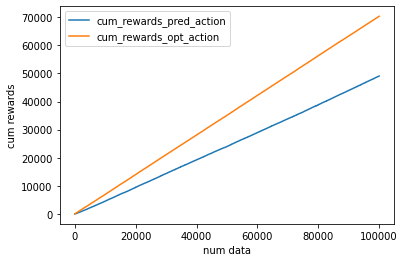

In [26]:
import matplotlib.pyplot as plt
plt.plot(cum_rewards_pred_action, label = 'cum_rewards_pred_action')
plt.plot(cum_rewards_opt_action, label = 'cum_rewards_opt_action')
plt.legend()
plt.xlabel('num data')
_ = plt.ylabel('cum rewards')

In [27]:
np.sum(pred_actions == opt_actions)/num_data

0.70715